In [ ]:
# Download the ROCO dataset from Kaggle
! kaggle datasets download virajbagal/roco-dataset

Dataset URL: https://www.kaggle.com/datasets/virajbagal/roco-dataset
License(s): CC0-1.0
100%|██████████████████████████████████████▉| 6.18G/6.19G [00:37<00:00, 143MB/s]
100%|███████████████████████████████████████| 6.19G/6.19G [00:38<00:00, 175MB/s]


In [ ]:
# Unzip the downloaded dataset
! unzip roco-dataset.zip

In [ ]:
# Install necessary libraries: kaggle, spacy, and nltk
!pip install kaggle
!pip install spacy
!pip install nltk

# Import required libraries for data processing and manipulation
import os
import pandas as pd
from PIL import Image, UnidentifiedImageError
import numpy as np
import re
import torch
import torchvision.transforms as transforms
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
import nltk

# Download and load the spaCy model for text processing
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Download NLTK data for stopwords and lemmatizatio
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Load the dataset CSV files
train_caption_df = pd.read_csv('/home/sagemaker-user/xray-images/all_data/test/radiologytestdata.csv')
val_caption_df = pd.read_csv('/home/sagemaker-user/xray-images/all_data/validation/radiologyvaldata.csv')
test_caption_df = pd.read_csv('/home/sagemaker-user/xray-images/all_data/test/radiologytestdata.csv')


In [ ]:
# Function to preprocess text by cleaning and normalizing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|ftp\S+', '', text) # removing the links
    text = text.replace('\n', ' ') # removing the new lines
    text = re.sub(r'\w*\d\w*', '', text) # removing the words containing numbers
    text = re.sub(r'\s+', ' ', text).strip() # removing the spaces
    text = re.sub(r'[^\w\s]', '', text) # removing special characters
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words] # considering only normal words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words] # considering the stemmed words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words] #considering the lemmatized words
    text = ' '.join(words)
    return text

In [ ]:
# Reload the dataset CSV files
train_caption_df = pd.read_csv('/home/sagemaker-user/xray-images/all_data/train/radiologytraindata.csv')
val_caption_df = pd.read_csv('/home/sagemaker-user/xray-images/all_data/validation/radiologyvaldata.csv')
test_caption_df = pd.read_csv('/home/sagemaker-user/xray-images/all_data/test/radiologytestdata.csv')

In [ ]:
# Apply text preprocessing to the caption data
train_caption_df['cleaned_caption'] = train_caption_df['caption'].apply(preprocess_text)
val_caption_df['cleaned_caption'] = val_caption_df['caption'].apply(preprocess_text)
test_caption_df['cleaned_caption'] = test_caption_df['caption'].apply(preprocess_text)

In [ ]:
# Display the first few rows of the preprocessed training data
train_caption_df.head()

,id,name,caption,cleaned_caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...,comput tomographi scan axial view show obliter...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...,bacteri contamin occur complet root canal trea...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...,patient residu paralysi hand poliomyel necessa...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n,panoram radiograph immedi load
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...,plain abdomen xray multipl air level midabdome...


Model 1

In [ ]:
# Define a function to preprocess images by resizing and normalizing
def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
        img_tensor = img_tensor.to(device)
        return img_tensor
    except UnidentifiedImageError:
        print(f"Cannot identify image file: {image_path}")
        return None

In [ ]:
# Define directories for training, validation, and test images
train_image_dirs = ['/home/sagemaker-user/xray-images/all_data/train/non-radiology/images/',
                    '/home/sagemaker-user/xray-images/all_data/train/radiology/images/']
val_image_dirs = ['/home/sagemaker-user/xray-images/all_data/validation/non-radiology/images/',
                  '/home/sagemaker-user/xray-images/all_data/validation/radiology/images/']
test_image_dirs = ['/home/sagemaker-user/xray-images/all_data/test/non-radiology/images/',
                   '/home/sagemaker-user/xray-images/all_data/test/radiology/images/']

In [ ]:
# Define a function to locate images in the specified directories
def find_image(image_name, image_dirs):
    for dir in image_dirs:
        image_path = os.path.join(dir, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

In [ ]:
# Initialize an empty list to store preprocessed data
preprocessed_data = []

In [ ]:
# Define a function to process and save the dataset
import torch

def process_and_save_dataset(df, set_name, image_dirs):
    preprocessed_data = []
    max_samples = 1000
    processed_samples = 0

    for index, row in df.iterrows():
        if processed_samples >= max_samples:
            break
        image_path = find_image(row['name'], image_dirs)
        if image_path:
            preprocessed_image = preprocess_image(image_path)
            if preprocessed_image is not None:
                preprocessed_data.append((row['cleaned_caption'], preprocessed_image.cpu()))
                processed_samples += 1
        else:
            print(f"Image {row['name']} not found.")

    captions = [item[0] for item in preprocessed_data]
    images = [item[1] for item in preprocessed_data]

    # Save the preprocessed data to a .pt file
    torch.save({'captions': captions, 'images': images}, f'{set_name}_preprocessed_data.pt')

    print(f'{set_name} preprocessed data saved to {set_name}_preprocessed_data.pt')

In [ ]:
# Define the device for computation (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Process and save the training, validation, and test datasets
process_and_save_dataset(train_caption_df, 'train', train_image_dirs)
process_and_save_dataset(val_caption_df, 'val', val_image_dirs)
process_and_save_dataset(test_caption_df, 'test', test_image_dirs)

train preprocessed data saved to train_preprocessed_data.pt
val preprocessed data saved to val_preprocessed_data.pt
test preprocessed data saved to test_preprocessed_data.pt


In [ ]:
# Install torchtext for text processing
pip install torchtext

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load the preprocessed dataset
train_data = torch.load('train_preprocessed_data.pt')
val_data = torch.load('val_preprocessed_data.pt')
test_data = torch.load('test_preprocessed_data.pt')


In [ ]:
# Import required libraries for building and training the model
import torch
import torch.nn as nn
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset,DataLoader
import torchvision.models as models

# Tokenize the captions by splitting into words
def tokenize_caption(caption):
    return caption.split()

# Build the vocabulary from the training captions
def yield_tokens(data):
    for caption in data['captions']:
        yield tokenize_caption(caption)

# Create a vocabulary object from the training captions
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<pad>", "<sos>", "<eos>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Define a function to numericalize and pad the captions
def numericalize_caption(caption, vocab, max_length=20):
    tokens = tokenize_caption(caption)
    tokens = ["<sos>"] + tokens + ["<eos>"]
    token_ids = vocab(tokens)
    if len(token_ids) < max_length:
        token_ids += [vocab["<pad>"]] * (max_length - len(token_ids))
    else:
        token_ids = token_ids[:max_length]
    return torch.tensor(token_ids)

# Define a custom dataset class for handling image-caption pairs
class CustomDataset(Dataset):
    def __init__(self, data, vocab, transform=None, max_length=20):
        self.data = data
        self.vocab = vocab
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data['captions'])

    def __getitem__(self, idx):
        caption = self.data['captions'][idx]
        image = self.data['images'][idx]

        # Ensure no extra dimension is added to the image tensor
        caption = numericalize_caption(caption, self.vocab, self.max_length)
        return image.squeeze(0), caption


In [ ]:
# Create dataset objects for training, validation, and testing
train_dataset = CustomDataset(train_data, vocab, transform=None)
val_dataset = CustomDataset(val_data, vocab, transform=None)
test_dataset = CustomDataset(test_data, vocab, transform=None)

In [ ]:
# Create DataLoader instances for batching and shuffling data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Define a custom model class for the image captioning task
class ImageCaptioningModel(nn.Module):
    def __init__(self, cnn_model_name, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptioningModel, self).__init__()
        self.cnn_model_name = cnn_model_name
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        if cnn_model_name == 'vgg':
            self.cnn = models.vgg16(pretrained=True)
            self.cnn.classifier[-1] = nn.Linear(self.cnn.classifier[-1].in_features, embed_size)
        elif cnn_model_name == 'resnet':
            self.cnn = models.resnet50(pretrained=True)
            self.cnn.fc = nn.Linear(self.cnn.fc.in_features, embed_size)
        elif cnn_model_name == 'efficientnet':
            self.cnn = models.efficientnet_b0(pretrained=True)
            self.cnn.classifier[-1] = nn.Linear(self.cnn.classifier[-1].in_features, embed_size)

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn_input_size = embed_size * 2  # Because we are concatenating CNN output and embedded captions
        self.rnn = nn.LSTM(self.rnn_input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, images, captions):
        cnn_out = self.cnn(images)
        cnn_out = cnn_out.unsqueeze(1).repeat(1, captions.size(1), 1)

        embedded_captions = self.embedding(captions)
        rnn_input = torch.cat((cnn_out, embedded_captions), dim=2)

        rnn_out, _ = self.rnn(rnn_input)
        outputs = self.linear(rnn_out)
        return outputs


In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, captions in train_loader:
            images = images.to(model.device)
            captions = captions.to(model.device)

            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for images, captions in test_loader:
            images = images.to(model.device)
            captions = captions.to(model.device)

            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))
            total_loss += loss.item()

        avg_loss = total_loss / len(test_loader)
        print(f'Average Test Loss: {avg_loss:.4f}')

In [ ]:
# Set model parameters and initialize the model
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)
num_layers = 1
num_epochs = 10
learning_rate = 0.001


vgg_model = ImageCaptioningModel('vgg', embed_size, hidden_size, vocab_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.Adam(vgg_model.parameters(), lr=learning_rate)

# Train and Evaluate VGG Model
print("Training VGG Model")
train_model(vgg_model, train_loader, criterion, optimizer_vgg, num_epochs)
print("Evaluating VGG Model")
evaluate_model(vgg_model, test_loader, criterion)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training VGG Model
Epoch [1/10], Loss: 5.8930
Epoch [2/10], Loss: 5.1336
Epoch [3/10], Loss: 4.0198
Epoch [4/10], Loss: 4.9219
Epoch [5/10], Loss: 5.5566
Epoch [6/10], Loss: 4.9949
Epoch [7/10], Loss: 5.9203
Epoch [8/10], Loss: 5.6124
Epoch [9/10], Loss: 3.7834
Epoch [10/10], Loss: 5.8096
Evaluating VGG Model
Average Test Loss: 5.7654


Model 2


In [ ]:
# Define image transformations: resize and convert to tenso
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),          # Convert the image to a tensor
])

# Define a function to preprocess images
def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img)  # Apply transformations
        img_tensor = img_tensor.permute(1, 2, 0)
        img_tensor = img_tensor.to(device)  # Move the tensor to the specified device
        img_tensor = img_tensor.cpu().numpy()
        return img_tensor
    except UnidentifiedImageError:
        print(f"Cannot identify image file: {image_path}")
        return None

In [ ]:
# Define directories where images can be located
train_image_dirs = ['/home/sagemaker-user/xray-images/all_data/train/non-radiology/images/',
                    '/home/sagemaker-user/xray-images/all_data/train/radiology/images/']
val_image_dirs = ['/home/sagemaker-user/xray-images/all_data/validation/non-radiology/images/',
                  '/home/sagemaker-user/xray-images/all_data/validation/radiology/images/']
test_image_dirs = ['/home/sagemaker-user/xray-images/all_data/test/non-radiology/images/',
                   '/home/sagemaker-user/xray-images/all_data/test/radiology/images/']

In [ ]:

# Define a function to find the image in the specified directories
def find_image(image_name, image_dirs):
    for dir in image_dirs:
        image_path = os.path.join(dir, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

In [ ]:
# Initialize an empty list to store preprocessed data
preprocessed_data = []

In [ ]:
# Define the device for computation (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Import necessary libraries for data manipulation
import pandas as pd
import torch

# Define a function to process and save the dataset
def process_and_save_dataset(df, set_name, image_dirs):
    preprocessed_data = []
    max_samples = 1000
    processed_samples = 0

    for index, row in df.iterrows():
        if processed_samples >= max_samples:
            break
        image_path = find_image(row['name'], image_dirs)
        if image_path:
            preprocessed_image = preprocess_image(image_path)
            if preprocessed_image is not None:
                preprocessed_data.append((row['cleaned_caption'], preprocessed_image))
                processed_samples += 1
        else:
            print(f"Image {row['name']} not found.")

    # Create a DataFrame from the preprocessed data
    preprocessed_df = pd.DataFrame(preprocessed_data, columns=['cleaned_caption', 'image_tensor'])

    print(f'{set_name} preprocessed data has been stored in a DataFrame.')

    return preprocessed_df


In [ ]:
# Process and save the training, validation, and test datasets
train_preprocessed_df = process_and_save_dataset(train_caption_df, 'train', train_image_dirs)
val_preprocessed_df = process_and_save_dataset(val_caption_df, 'val', val_image_dirs)
test_preprocessed_df = process_and_save_dataset(test_caption_df, 'test', test_image_dirs)

train preprocessed data has been stored in a DataFrame.
val preprocessed data has been stored in a DataFrame.
test preprocessed data has been stored in a DataFrame.


In [ ]:
# Display the first few rows of the preprocessed training data
train_preprocessed_df.head()

,cleaned_caption,image_tensor
0,comput tomographi scan axial view show obliter...,"[[[0.16078432, 0.15294118, 0.15686275], [0.164..."
1,bacteri contamin occur complet root canal trea...,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
2,patient residu paralysi hand poliomyel necessa...,"[[[0.4117647, 0.4117647, 0.4117647], [0.211764..."
3,panoram radiograph immedi load,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
4,plain abdomen xray multipl air level midabdome...,"[[[0.47843137, 0.47843137, 0.47843137], [0.388..."


In [ ]:
# Import necessary libraries for text processing and model building
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Define a function to preprocess text by tokenizing and sequencing
def preprocess_text(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    sequences = tokenizer.texts_to_sequences(captions)
    max_length = max(len(seq) for seq in sequences)
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    return tokenizer, max_length, vocab_size

In [ ]:
# Preprocess the training captions
train_captions = train_preprocessed_df['cleaned_caption']
tokenizer, max_length, vocab_size = preprocess_text(train_captions)

In [ ]:
# Define a function to create sequences for model input
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = [], [], []
    for i in range(len(descriptions)):
        desc = descriptions[i]
        photo = photos[i]
        seq = tokenizer.texts_to_sequences([desc])[0]
        for j in range(1, len(seq)):
            in_seq, out_seq = seq[:j], seq[j]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq_vec = np.zeros(vocab_size)
            out_seq_vec[out_seq] = 1
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq_vec)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
# Create sequences for training data
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_preprocessed_df['cleaned_caption'],train_preprocessed_df['image_tensor'])

In [ ]:
# Define the image captioning model using InceptionV3 and LSTM
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(224, 224, 3))
    model = InceptionV3(include_top=False, pooling='avg')
    for layer in model.layers:
        layer.trainable = False
    fe1 = model(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = define_model(vocab_size, max_length)
model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 78)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 78, 256)              814080    ['input_6[0][0]']             
                                                                                                  
 inception_v3 (Functional)   (None, 2048)                 2180278   ['input_4[0][0]']             
                           

In [ ]:
# Set training parameters
epochs = 10
batch_size = 64

In [ ]:
# Compile the model with additional accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit([X1train, X2train], ytrain, epochs=epochs, batch_size=batch_size, validation_split=0.2)

2024-07-05 10:09:18.735804: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6147563520 exceeds 10% of free system memory.


Epoch 1/10
160/160 [==============================] - 136s 814ms/step - loss: 7.2387 - accuracy: 0.0397 - val_loss: 7.0585 - val_accuracy: 0.0431
Epoch 2/10
160/160 [==============================] - 127s 793ms/step - loss: 6.5924 - accuracy: 0.0502 - val_loss: 7.1526 - val_accuracy: 0.0521
Epoch 3/10
160/160 [==============================] - 127s 793ms/step - loss: 6.1538 - accuracy: 0.0685 - val_loss: 7.1406 - val_accuracy: 0.0678
Epoch 4/10
160/160 [==============================] - 127s 795ms/step - loss: 5.6230 - accuracy: 0.0871 - val_loss: 7.2780 - val_accuracy: 0.0776
Epoch 5/10
160/160 [==============================] - 127s 794ms/step - loss: 5.0209 - accuracy: 0.1083 - val_loss: 7.6905 - val_accuracy: 0.0732
Epoch 6/10
160/160 [==============================] - 127s 797ms/step - loss: 4.3645 - accuracy: 0.1301 - val_loss: 8.1476 - val_accuracy: 0.0638
Epoch 7/10
160/160 [==============================] - 127s 796ms/step - loss: 3.7622 - accuracy: 0.1604 - val_loss: 8.8571 -

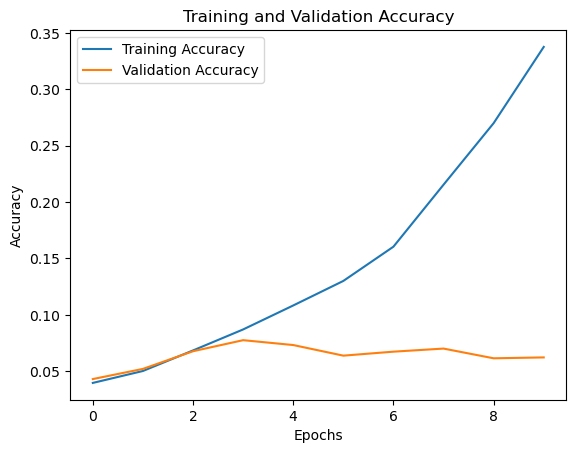

In [ ]:
# Access and plot training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
